# PDAC Subtype Classification using Gene Signatures


Dataset:

• GSE71729(keep only PDAC primary samples)

• Downloadable from the GEO website

Tasks:

• Predict the cancer subtypes based on the signatures

• Identify top N most important genes

• Build new models using only important features

• Compare the performance and stability of two prediction models:

• Suggested ML algorithms: Random Forest, Grand Forest, or other suitable algorithms

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE




# Load data

In [4]:
# File paths
gene_expression_path = r"C:\Users\sharm\Desktop\UNI\1. Sem Python\data provided\gene expression.csv"
gene_signatures_path = r"C:\Users\sharm\Desktop\UNI\1. Sem Python\data provided\gene signatures.csv"
metadata_path = r"C:\Users\sharm\Desktop\UNI\1. Sem Python\data provided\metadata.csv"

In [5]:
# Load data
gene_expression = pd.read_csv(gene_expression_path, index_col=0)
gene_signatures = pd.read_csv(gene_signatures_path)['gene'].tolist()
metadata = pd.read_csv(metadata_path)

## Preprocessing

### check for data imbalance

In [6]:
# Check for data imbalance in 'tumor_subtype_0na_1classical_2basal:ch2'
subtype_counts = metadata['tumor_subtype_0na_1classical_2basal:ch2'].value_counts()

print("\nTumor Subtype Counts:")
print(subtype_counts)

# Determine if there's an imbalance
if len(subtype_counts) == 2:  # Ensure we have both classes present
    classical_count = subtype_counts.get(1, 0)
    basal_count = subtype_counts.get(2, 0)
    
    print(f"\nClassical Tumor Count: {classical_count}")
    print(f"Basal Tumor Count: {basal_count}")
    
    if classical_count != basal_count:
        print("\nThere is a data imbalance between the classical and basal tumor types.")
    else:
        print("\nThe dataset is balanced for the tumor subtypes.")
else:
    print("\nOne or more classes are missing in the dataset.")


Tumor Subtype Counts:
1    103
2     42
Name: tumor_subtype_0na_1classical_2basal:ch2, dtype: int64

Classical Tumor Count: 103
Basal Tumor Count: 42

There is a data imbalance between the classical and basal tumor types.


In [7]:
filtered_gene_expression = gene_expression.loc[gene_signatures].T
filtered_gene_expression.index.name = 'geo_accession'
merged_data = metadata.merge(filtered_gene_expression, left_on='geo_accession', right_index=True)

X = merged_data[gene_signatures]
y = merged_data['tumor_subtype_0na_1classical_2basal:ch2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Train model 1- Random forest

### Cross Validation-RF

In [119]:

rf_model_cv = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_scores = cross_val_score(rf_model_cv, X_train, y_train, cv=5)
print("Initial RF Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (rf_scores.mean(), rf_scores.std() * 2))


Initial RF Cross-Validation Accuracy: 0.88 (+/- 0.10)


### Hyper-parameter tuning- RF

In [120]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model_cv, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.9047101449275361


### train RF best model

In [121]:
rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
# Evaluate the tuned model on the test set
test_accuracy = rf_model.score(X_test, y_test)
print("Test Set Accuracy of Best Model: %0.2f" % test_accuracy)

Test Set Accuracy of Best Model: 0.90


In [122]:
y_pred_rf = rf_model.predict(X_test)
print("Tuned Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Tuned Random Forest Performance:
Accuracy: 0.896551724137931
              precision    recall  f1-score   support

           1       0.88      1.00      0.93        21
           2       1.00      0.62      0.77         8

    accuracy                           0.90        29
   macro avg       0.94      0.81      0.85        29
weighted avg       0.91      0.90      0.89        29



## Train model 2- Random forest with selected features

In [123]:
# Train Random Forest for feature importance
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.02687306 0.00692794 0.0425714  0.01043746 0.00707397 0.00602195
 0.00894195 0.02699107 0.03606623 0.01839982 0.00306005 0.00478298
 0.03981658 0.01462789 0.01592252 0.02648467 0.0060834  0.00331503
 0.03175724 0.00246357 0.00930153 0.005356   0.01376012 0.0083397
 0.02011504 0.0054992  0.00778539 0.02154192 0.00768644 0.00339785
 0.01417761 0.00732711 0.02422016 0.01321227 0.00629443 0.01612657
 0.00942088 0.0155079  0.01499137 0.0491688  0.01293943 0.13250615
 0.07614846 0.00834863 0.0046249  0.00436324 0.08345514 0.01065621
 0.01701487 0.03809388]


In [124]:
# Select the top 'n' important features
n = 20  
indices_of_important_features = np.argsort(feature_importances)[-n:]

# Reduce the training and test sets to only the important features
X_train_rf_top = X_train.iloc[:, indices_of_important_features]
X_test_rf_top = X_test.iloc[:, indices_of_important_features]

# Print selected features if feature names are available
print("Selected Features (by index):", indices_of_important_features)

Selected Features (by index): [37 14 35 48  9 24 27 32 15  0  7 18  8 49 12  2 39 42 46 41]


In [125]:
# Now retrain a Random Forest model with the selected features
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],     # Maximum depth of the tree
    'min_samples_split': [2, 5],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node
}

# Perform Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_rf_top, y_train)

# Best parameters from Grid Search
best_params_rf = grid_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [126]:
# Train the Random Forest model with the selected features using the best parameters
rf_model_top = RandomForestClassifier(**best_params_rf, random_state=42)
rf_model_top.fit(X_train_rf_top, y_train)

# Make predictions and evaluate the optimized Random Forest model
pred_rf_top = rf_model_top.predict(X_test_rf_top)
print("Optimized Random Forest with Important Features Report")
print(classification_report(y_test, pred_rf_top))

# Optional: Re-evaluate cross-validation accuracy with the best parameters
cv_scores_optimized_rf = cross_val_score(rf_model_top, X_train_rf_top, y_train, cv=5, scoring='accuracy')
print("Optimized Random Forest Cross-Validation Accuracy with Selected Features:", np.mean(cv_scores_optimized_rf))

Optimized Random Forest with Important Features Report
              precision    recall  f1-score   support

           1       0.90      0.90      0.90        21
           2       0.75      0.75      0.75         8

    accuracy                           0.86        29
   macro avg       0.83      0.83      0.83        29
weighted avg       0.86      0.86      0.86        29

Optimized Random Forest Cross-Validation Accuracy with Selected Features: 0.9137681159420289


Random Forest Accuracy (All Features): 0.90
Random Forest Accuracy (Selected Features): 0.86


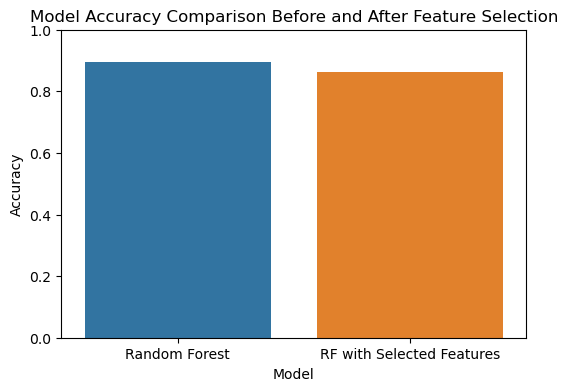

In [127]:
# Compare accuracies before and after feature selection
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_top_accuracy = accuracy_score(y_test, pred_rf_top)

print(f"Random Forest Accuracy (All Features): {rf_accuracy:.2f}")
print(f"Random Forest Accuracy (Selected Features): {rf_top_accuracy:.2f}")

# Visualize comparison
metrics = {
    'Model': ['Random Forest', 'RF with Selected Features'],
    'Accuracy': [rf_accuracy, rf_top_accuracy]
}
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Accuracy Comparison Before and After Feature Selection')
plt.ylim(0, 1)
plt.show()

# Train model 3- SVM

In [128]:
# Create a StratifiedKFold object with the desired number of splits
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVM Model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Perform stratified cross-validation
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_k_fold)

# Print the mean accuracy and standard deviation
print("Stratified SVM Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (svm_scores.mean(), svm_scores.std() * 2))


Stratified SVM Cross-Validation Accuracy: 0.94 (+/- 0.07)


In [129]:
# Define parameter grid for SVM including class_weight
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

# Choose a metric that handles imbalance better, e.g., 'f1' or 'roc_auc'
svm_grid_search = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='f1')

# Fit the grid search object
svm_grid_search.fit(X_train, y_train)

# Print results
print("Best Parameters for SVM:", svm_grid_search.best_params_)
print("Best Cross-Validated Score for SVM:", svm_grid_search.best_score_)


Best Parameters for SVM: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Best Cross-Validated Score for SVM: 0.9646956964604023


In [130]:
svm_model = SVC(**svm_grid_search.best_params_)
svm_model.fit(X_train, y_train)


SVC(C=0.1, class_weight='balanced', kernel='linear')

In [131]:
y_pred_svm = svm_model.predict(X_test)
print("Tuned SVM Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Tuned SVM Performance:
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00         8

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [132]:
svm_accuracy = accuracy_score(y_test, y_pred_svm) 
print (svm_accuracy)

1.0


## Train model 4- SVM with selected features

In [133]:
# Fit RFE with SVM classifier
svc = SVC(kernel="linear", random_state=42)
rfe = RFE(estimator=svc, n_features_to_select=20)  
X_train_top_svm = rfe.fit_transform(X_train, y_train)

# Select the same features in the test set
X_test_top_svm = rfe.transform(X_test)

# Optional: Check which features were selected
selected_features = rfe.support_
print("Selected Features:", selected_features)

Selected Features: [False False  True  True False False False  True False False False False
  True False  True  True  True False  True False False False False False
  True False False False False  True False False  True False False  True
 False  True  True  True  True  True  True False False False  True  True
 False False]


In [134]:
# hyperparameter tuning and model evaluation
svm_param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear'],  # Using linear kernel
    'class_weight': ['balanced']  # To handle class imbalance
}

# Perform Grid Search with Cross-Validation
grid_search_svm = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_top_svm, y_train)

# Best parameters from Grid Search
best_params = grid_search_svm.best_params_
print("Best Parameters for SVM with selected features:", best_params)
print("Best Cross-Validated Score for SVM with Selected Features:", svm_grid_search.best_score_)


Best Parameters for SVM with selected features: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Best Cross-Validated Score for SVM with Selected Features: 0.9646956964604023


In [135]:
# Train the SVM model with selected features using the best parameters
svm_model_top = SVC(**best_params, random_state=42)
svm_model_top.fit(X_train_top_svm, y_train)

# Make predictions and evaluate the optimized SVM model
pred_svm_top = svm_model_top.predict(X_test_top_svm)
print("SVM with Top Features Report")
print(classification_report(y_test, pred_svm_top))

# Optional: Re-evaluate cross-validation accuracy with the best parameters
cv_scores_optimized_svm = cross_val_score(svm_model_top, X_train_top_svm, y_train, cv=5, scoring='accuracy')
print("SVM Cross-Validation Accuracy with Selected Features:", np.mean(cv_scores_optimized_svm))

SVM with Top Features Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00         8

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

SVM Cross-Validation Accuracy with Selected Features: 0.9826086956521738


## Accuracy score of training and testing dataset

In [136]:
# Predicting on the training set
y_train_pred = rf_model.predict(X_train)

# Predicting on the testing set
y_test_pred = rf_model.predict(X_test)

# Calculating accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the accuracies
print(f"Training Set Accuracy RF: {train_accuracy:.2f}")
print(f"Testing Set Accuracy RF: {test_accuracy:.2f}")


Training Set Accuracy RF: 1.00
Testing Set Accuracy RF: 0.90


In [137]:
# Predicting on the training set
y_train_pred = rf_model_top.predict(X_train_rf_top)

# Predicting on the testing set
y_test_pred = rf_model_top.predict(X_test_rf_top)

# Calculating accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the accuracies
print(f"Training Set Accuracy RF-selected features: {train_accuracy:.2f}")
print(f"Testing Set Accuracy RF- selected features: {test_accuracy:.2f}")

Training Set Accuracy RF-selected features: 1.00
Testing Set Accuracy RF- selected features: 0.86


In [138]:
# Predicting on the training set
y_train_pred = svm_model.predict(X_train)

# Predicting on the testing set
y_test_pred = svm_model.predict(X_test)

# Calculating accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the accuracies
print(f"Training Set Accuracy SVM: {train_accuracy:.2f}")
print(f"Testing Set Accuracy SVM: {test_accuracy:.2f}")

Training Set Accuracy SVM: 1.00
Testing Set Accuracy SVM: 1.00


In [145]:
# Calculate accuracy on the training set
train_predictions = svc.predict(X_train_top_svm)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Set Accuracy: %0.2f" % train_accuracy)

# Calculate accuracy on the test set
test_predictions = svc.predict(X_test_top_svm)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Set Accuracy: %0.2f" % test_accuracy)

Training Set Accuracy: 1.00
Test Set Accuracy: 1.00


# Compare metrics

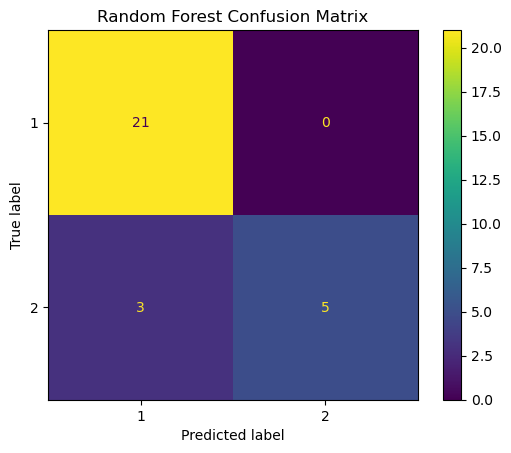

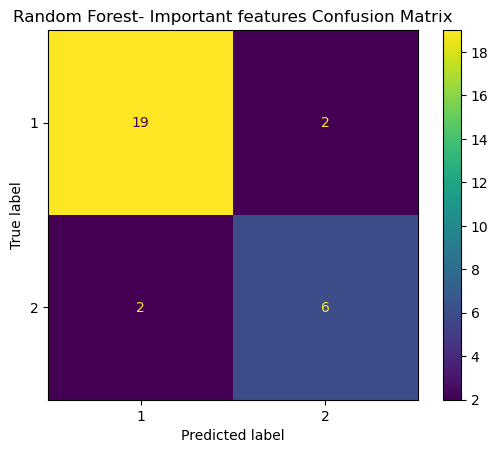

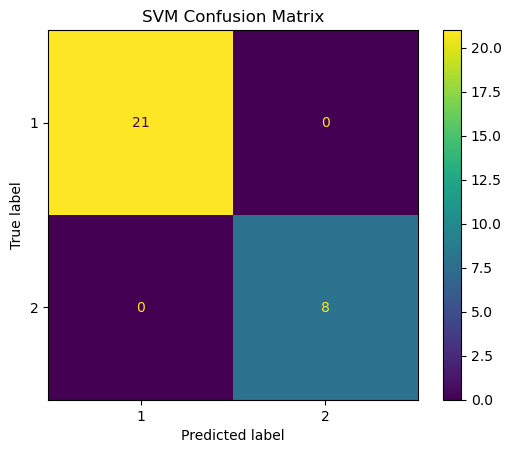

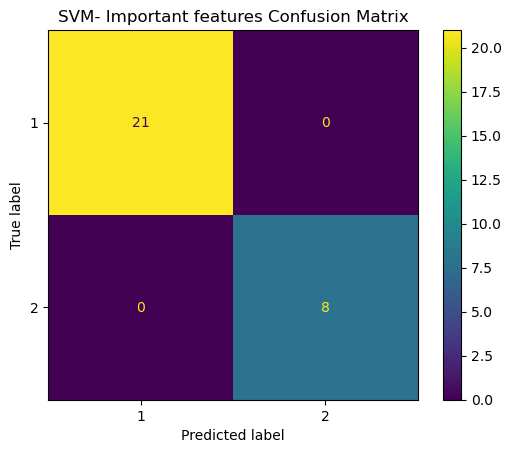

In [140]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test).ax_.set_title('Random Forest Confusion Matrix')
plt.show()

ConfusionMatrixDisplay.from_estimator(rf_model_top, X_test_rf_top, y_test).ax_.set_title('Random Forest- Important features Confusion Matrix')
plt.show()


ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test).ax_.set_title('SVM Confusion Matrix')
plt.show()

ConfusionMatrixDisplay.from_estimator(svm_model_top, X_test_top_svm, y_test).ax_.set_title('SVM- Important features Confusion Matrix')
plt.show()

# compare metrics

Random Forest Accuracy: 0.90
Random Forest with Selected Features Accuracy: 0.86
SVM Accuracy: 1.00
SVM with Selected Features Accuracy: 1.00


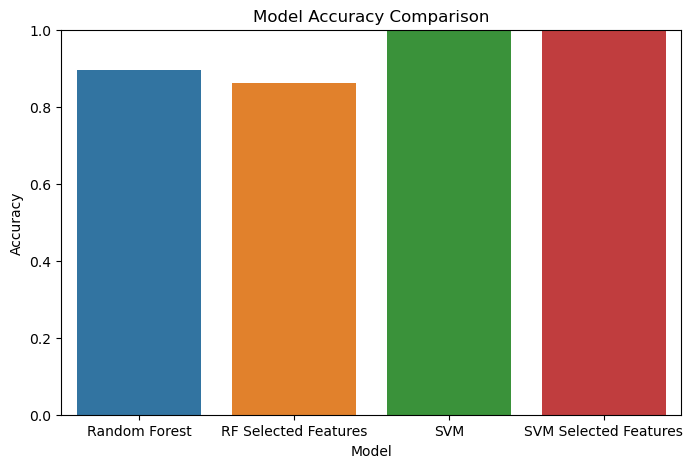

In [142]:
# Compare accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_top_accuracy = accuracy_score(y_test, pred_rf_top)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_top_accuracy = accuracy_score(y_test, pred_svm_top)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Random Forest with Selected Features Accuracy: {rf_top_accuracy:.2f}")
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print(f"SVM with Selected Features Accuracy: {svm_top_accuracy:.2f}")

# Visualize model comparison
metrics = {'Model': ['Random Forest', 'RF Selected Features', 'SVM', 'SVM Selected Features'], 'Accuracy': [rf_accuracy, rf_top_accuracy, svm_accuracy, svm_top_accuracy]}
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()
